Apply the constructed fisheries metric to CESM
- start with CORE normal year run
- move to decadal prediction

Need:
- SST
- POC flux to benthos (need index of last/deepest element, only have to do one time)
- NPP

How do the temp, NPP and POC flux data compare across the models and across the model runs?

Does this result in a different fisheries metric fit? How different?



In [1]:
# Convert to gC m-2 yr-1 =>*864*12*365*0.001
cfactor  = 864*12*365*0.001
# Charlie's data is in these units

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import netCDF4 as nc

In [3]:
import scipy.optimize as optimization
import scipy.stats as stats

In [4]:
# for pretty plots:
from cmocean import cm

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [5,5]
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['savefig.dpi'] = 200

mpl.rcParams['font.size'] = 16
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'
mpl.rcParams['lines.linewidth']= 2.0

/anaconda3/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [5]:
# grab data

# use lme mask 
cdata = nc.Dataset("LME_x1_mask.nc", 'r')
cmask = cdata.variables['LME_MASK'][:]

# get tarea and SST
myfile = 'mean.nday1.nc'
mydata = nc.Dataset(myfile,'r')
sst = mydata.variables['SST'][0,:,:]
tarea = mydata.variables['TAREA'][:]  
kmt = mydata.variables['KMT'][:]

FileNotFoundError: [Errno 2] No such file or directory: b'LME_x1_mask.nc'

In [6]:
# get NPP
nfile =  'mean_NPP_5yr.nc'
ndata = nc.Dataset(nfile,'r')
NPP = ndata.variables['NPP'][:,:] 
# Convert to gC m-2 yr-1 =>*864*12*365*0.001
cfactor  = 864*12*365*0.001
NPP = NPP*cfactor

/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:1046: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)


Extract bottom POC flux in LMES

Need to:
- find bottom valid k for each lat,lon point = KMT in standard output (nday1)
- extract POC flux at these points (just loop)








In [7]:
# get POC (full water column)

pfile = 'mean_POC_FLUX_IN.nc'
pdata = nc.Dataset(pfile,'r')
PF = pdata.variables['POC_FLUX_IN'][0,:,:,:]
PF = PF*cfactor
tlat = pdata.variables['TLAT'][:,:]
tlon = pdata.variables['TLONG'][:,:]

/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:1046: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)


In [8]:
# make array of POC_FLUX at bottom

# initialzie
PF_bot = np.zeros_like(NPP)

# loop over elements
for i in range(0,384):
    for j in range(0,320):
        if kmt[i,j] == 0:
            PF_bot[i,j] = np.NAN
        else:
            PF_bot[i,j] = PF[(kmt[i,j]-1),i,j]

# could take 100 m offshelf (play around later)

# get mean SST and NPP in LMEs

In [9]:
# get mean SST in each LME, area weighted
# initialize mean sst array
sst_lme = np.zeros([66])
sst_lme[:] = -1

# loop over LMEs
for lme in range(1,66+1):
    # calculate mean sst in LME
     sst_lme[lme-1] = np.ma.average(sst[cmask == lme], weights = tarea[cmask == lme])
    

In [10]:
sst_lme

array([  4.65560771,   9.1437219 ,  17.64419396,  24.72800805,
        26.12788805,  25.30218517,  17.3455239 ,  10.72091631,
         5.68452799,  24.7608815 ,  27.47220887,  27.67627935,
        17.02002683,  11.05119378,  23.257822  ,  27.05134029,
        28.18914119,  -0.30222259,   0.6654405 ,   0.35390351,
         6.52514393,   9.71064778,   7.44399674,  12.9105395 ,
        16.5881638 ,  19.14199242,  21.7166679 ,  27.59434199,
        21.47338624,  25.57113159,  27.37989926,  27.16741208,
        27.89351114,  28.17074688,  28.99283837,  27.73900851,
        28.81428588,  28.79398815,  28.45791698,  26.5790228 ,
        22.52505329,  14.41898655,  16.97715838,  22.1062753 ,
        27.58016028,  15.15691877,  21.79791344,  14.53371125,
        23.1771177 ,  12.1486087 ,   6.68397988,   3.37807395,
         3.8800207 ,  -0.36553755,  -1.23681555,  -1.61865786,
        -1.55621958,  -1.28144957,   4.89674699,   9.59345074,
        -0.95665652,  15.43734948,   0.05097987,  -1.72

In [11]:
# get mean NPP in each LME
# initialize mean sst array
npp_lme = np.zeros([66])
npp_lme[:] = -1

# loop over LMEs
for lme in range(1,66+1):
    # calculate mean in LME
     npp_lme[lme-1] = np.ma.average(NPP[cmask == lme], weights = tarea[cmask == lme])
   

In [12]:
npp_lme

array([ 176.1768848 ,  129.81430815,  138.27848684,  204.0337978 ,
         96.32872954,   98.95863572,  151.26475642,  135.52439375,
        124.60874852,  116.8794646 ,  246.73740624,  107.39147404,
        190.57761438,  224.65761977,  121.99544264,  130.17601499,
        135.12601791,   81.55682454,   89.03218568,   76.12821076,
        122.71477214,  108.46414336,    0.        ,  140.97893987,
        131.06731649,   68.40858382,  184.33921483,  176.05834502,
        222.8292378 ,  171.66152352,  205.26503671,  238.55423646,
          0.        ,  203.73688183,  126.42997493,  144.45128438,
        159.65073605,  192.37153531,  201.0342272 ,  146.85625845,
        150.9279254 ,  149.25386735,  130.11986159,  141.71925628,
        198.57893925,  145.31687827,  149.21937085,   93.77661006,
        140.50898176,  121.42002232,  177.49354971,  185.68844663,
        177.85950948,  108.54962574,   46.5738082 ,   54.398551  ,
         52.4608656 ,   46.34173977,  130.97539425,  170.35887

In [13]:
# get mean FD in each LME

# initialize mean arrays
fd_lme = np.zeros([66])
fd_lme[:] = -1
mean_fd_lme = np.copy(cmask)

# loop over LMEs
for lme in range(1,66+1):
    # calculate mean in LME
    fd_lme[lme-1] = np.ma.average(PF_bot[cmask == lme], weights = tarea[cmask == lme])
    # set lme equal to sst 
    mean_fd_lme[cmask == lme] = fd_lme[lme-1]

# reset mask
mean_fd_lme = np.ma.masked_where(np.ma.getmask(NPP),mean_fd_lme)

In [15]:
fd_lme

array([  2.68876702e+01,   5.81055825e+00,   1.38552078e+00,
         5.56157213e+00,   2.10641207e+00,   3.53218905e+00,
         1.52422798e+01,   1.73926578e+01,   1.62193142e+01,
         4.32238725e-01,   3.39163957e+00,   1.55201963e+00,
         3.47615341e+00,   5.04965157e+01,   4.67811979e+00,
         1.31220226e+00,   4.51459593e+00,   8.26921720e+00,
         4.99915692e+00,   1.18462342e+01,   4.46883299e+00,
         1.79314410e+01,   1.23438835e-08,   1.45375739e+01,
         1.91321231e+00,   2.19518873e+00,   4.14650347e+00,
         3.01744695e+00,   4.62915206e+00,   2.07160704e+00,
         2.00641306e+00,   5.56265677e+00,   1.16022708e-15,
         3.67783786e+00,   1.42072059e+01,   6.59088641e+00,
         4.54244791e+00,   6.25480253e+00,   2.79032540e+01,
         2.73143607e+00,   1.10085708e+00,   3.89964192e+00,
         3.55200258e+00,   2.08012855e+00,   1.01308487e+01,
         5.85873163e+00,   1.58505376e+01,   1.42648170e+01,
         1.41970740e+00,

In [107]:
fd_lme.shape

(66,)

# Use the same method as for GFDL output

Need to nan out the same LMEs as Charlie did

Here are the varibles for CESM:
- sst_lme
- npp_lme
- fd_lme




In [16]:
# need to get observed fish catch from Charlie's data

filenm = "catch_oceanprod_output.txt"
data = np.genfromtxt(filenm,  comments = '%', names = True, skip_header = 9)
Scatch = data['SAUcatch']
TL = data['TLeq']
LME = data['LME']
# Units: g C m-2 yr-1

In [18]:
LME

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  11.,  12.,
        13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  24.,
        25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  34.,  36.,  37.,
        38.,  46.,  47.,  49.,  50.,  51.,  52.,  53.,  54.,  59.,  60.,
        65.])

In [17]:
# Charlie skipped: 
# Hawaii:
# 10
# Marginal Seas:
# 23, 33, 35, 48, 63
# Australia:
# 39, 40, 41, 42, 43, 44, 45
# Arctic/Antarctic:
# 55, 56, 57, 58, 61, 62,  64, 66

skipped = [10, 23, 33, 35, 48, 63, 39, 40, 41, 42, 43, 44, 45, 55, 56, 57, 58, 61, 62, 64, 66]

In [19]:
# loop through LMEs and create new vars
T = []
FD = []
NPP = []
lme_num = []

i = 0
for lme in range(1,66+1):
    if lme not in skipped:
        lme_num.append(lme)
        NPP.append(npp_lme[lme-1])
        T.append(sst_lme[lme-1])
        FD.append(fd_lme[lme-1])
# note this did not fix the problem I was having
T = np.asarray(T)
NPP = np.asarray(NPP)
FD = np.asarray(FD)
        

In [23]:
lme_num

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 34,
 36,
 37,
 38,
 46,
 47,
 49,
 50,
 51,
 52,
 53,
 54,
 59,
 60,
 65]

In [20]:
T

array([  4.65560771,   9.1437219 ,  17.64419396,  24.72800805,
        26.12788805,  25.30218517,  17.3455239 ,  10.72091631,
         5.68452799,  27.47220887,  27.67627935,  17.02002683,
        11.05119378,  23.257822  ,  27.05134029,  28.18914119,
        -0.30222259,   0.6654405 ,   0.35390351,   6.52514393,
         9.71064778,  12.9105395 ,  16.5881638 ,  19.14199242,
        21.7166679 ,  27.59434199,  21.47338624,  25.57113159,
        27.37989926,  27.16741208,  28.17074688,  27.73900851,
        28.81428588,  28.79398815,  15.15691877,  21.79791344,
        23.1771177 ,  12.1486087 ,   6.68397988,   3.37807395,
         3.8800207 ,  -0.36553755,   4.89674699,   9.59345074,   6.0726801 ])

In [21]:
NPP

array([ 176.1768848 ,  129.81430815,  138.27848684,  204.0337978 ,
         96.32872954,   98.95863572,  151.26475642,  135.52439375,
        124.60874852,  246.73740624,  107.39147404,  190.57761438,
        224.65761977,  121.99544264,  130.17601499,  135.12601791,
         81.55682454,   89.03218568,   76.12821076,  122.71477214,
        108.46414336,  140.97893987,  131.06731649,   68.40858382,
        184.33921483,  176.05834502,  222.8292378 ,  171.66152352,
        205.26503671,  238.55423646,  203.73688183,  144.45128438,
        159.65073605,  192.37153531,  145.31687827,  149.21937085,
        140.50898176,  121.42002232,  177.49354971,  185.68844663,
        177.85950948,  108.54962574,  130.97539425,  170.35887011,
        182.72643613])

In [22]:
FD

array([ 26.88767021,   5.81055825,   1.38552078,   5.56157213,
         2.10641207,   3.53218905,  15.24227978,  17.39265778,
        16.21931421,   3.39163957,   1.55201963,   3.47615341,
        50.49651573,   4.67811979,   1.31220226,   4.51459593,
         8.2692172 ,   4.99915692,  11.84623418,   4.46883299,
        17.93144102,  14.53757389,   1.91321231,   2.19518873,
         4.14650347,   3.01744695,   4.62915206,   2.07160704,
         2.00641306,   5.56265677,   3.67783786,   6.59088641,
         4.54244791,   6.25480253,   5.85873163,  15.85053757,
         1.4197074 ,   4.33087141,   6.59412697,  28.01442178,
         6.42206059,  46.17681507,   9.68425089,  12.93476864,   4.80646063])

In [28]:
print(NPP.mean()), print(NPP.std())

151.534142785
43.2662163615


(None, None)

In [27]:
print(FD.mean())

9.20695076575


In [26]:
print(FD.std())

10.5417701652


In [110]:
FD.shape

(45,)

In [91]:
# NPP is the independent variables, but SST (T), is also in there, as is detridal flux FD, and TL from Charlie's data

def cfunc3(NPP,alpha,TE_P,TE_B,a,b,c):   
    # calculate predicted catch given alpha and TE
    z_r = a*NPP+b*T+c
    model_catch = alpha*(z_r*NPP*TE_P**(TL-1) + FD*TE_B**(TL-1))
    return np.log10(model_catch)

In [111]:
# need variables in above: TL, FD, T

params, cov = optimization.curve_fit(cfunc3, NPP, np.log10(Scatch), [0.14,0.16,0.16,0.1,-0.1,0])

/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in power
  


In [112]:
params

array([  1.09261174e-02,   9.46308012e-03,   1.21251061e+00,
         2.02891272e+08,   2.28341184e+06,  -1.18199996e+07])

In [113]:
#plot it
model_catch3 = 10**(cfunc3(NPP,params[0],params[1],params[2],params[3],params[4],params[5]))

In [115]:
# best line fit to catch-catch plot in log-log space
def lin(obs_catch, m, b):
    return m*np.log10(obs_catch)+b

In [116]:
# linear fit
lparams3, lcov3 = optimization.curve_fit(lin, Scatch, np.log10(model_catch3), [1,1])
print(lparams3)
print(lcov3)
# the m should not depend on the log-log, but the b is actually in log space
# np.log10(model_catch) = m*np.log10(obs_catch) + b

[ 0.49076241 -0.36984913]
[[ 0.00822301  0.00597219]
 [ 0.00597219  0.00588201]]


In [119]:
r,p = stats.pearsonr(np.log10(Scatch),np.log10(model_catch3))
print(r,p)

RMSE = np.sqrt(np.mean((Scatch-model_catch3)**2))
print(RMSE)

(0.63652920414269987, 2.6008303230135938e-06)
0.279701685652


In [121]:
T_warm = 20

Text(0.5,1,u'r = 0.64   RMSE = 0.28')

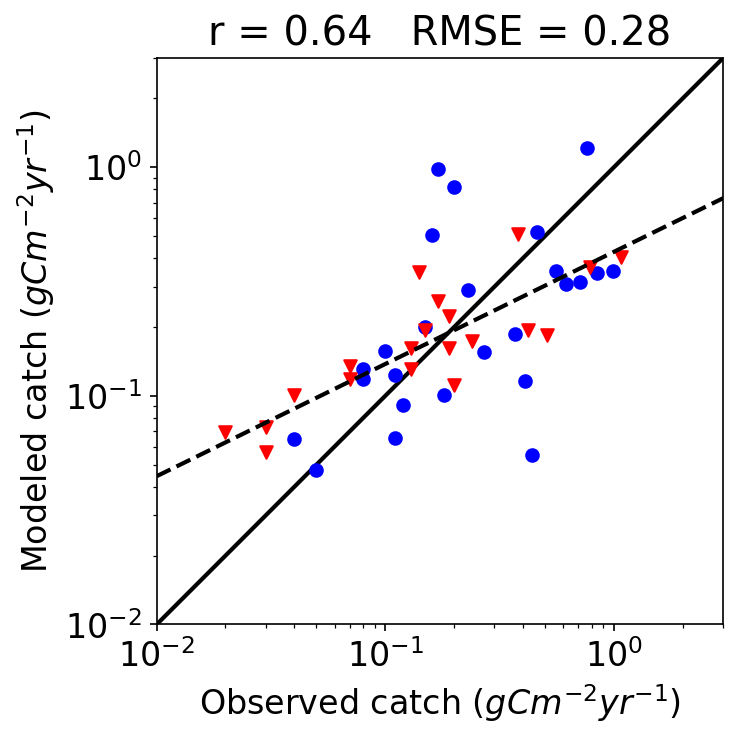

In [130]:
plt.plot([0.01,10],[0.01,10],'k', zorder = 0)
plt.plot([0.01,10],[(10**lparams3[1]*0.01**lparams3[0]),(10**lparams3[1]*10**lparams3[0])], 'k--')

plt.yscale('log')
plt.xscale('log')
plt.xlabel('Observed catch ($gCm^{-2}yr^{-1}$)')
plt.ylabel('Modeled catch ($gCm^{-2}yr^{-1}$)')

ax = plt.gca()

ax.scatter(Scatch[(T<T_warm)],model_catch3[(T<T_warm)], 
             marker = 'o', color = 'blue')
ax.scatter(Scatch[(T>T_warm)],model_catch3[(T>T_warm)], 
             marker = 'v', color = 'red')


# ax.scatter(Scatch[(T<T_warm) & (FD>ZP)],model_catch2[(T<T_warm) & (FD>ZP)], 
#             marker = 'v', color = 'blue')
# ax.scatter(Scatch[(T<T_warm) & (FD<ZP)],model_catch2[(T<T_warm) & (FD<ZP)], 
#             marker = 'o', color = 'blue')
# ax.scatter(Scatch[(T>T_warm) & (FD>ZP)],model_catch2[(T>T_warm) & (FD>ZP)], 
#             marker = 'v', color = 'red')
# ax.scatter(Scatch[(T>T_warm) & (FD<ZP)],model_catch2[(T>T_warm) & (FD<ZP)], 
#             marker = 'o', color = 'red')
ax.axis('square')

xmin = 0.01
xmax = 3
ax.set_xlim([xmin,xmax])
ax.set_ylim([xmin,xmax])

title = 'r = '+ '{:.2f}'.format(r) + '   RMSE = ' + '{:.2f}'.format(RMSE)
plt.title(title)

Text(0.5,1,u'r = 0.64   RMSE = 0.28')

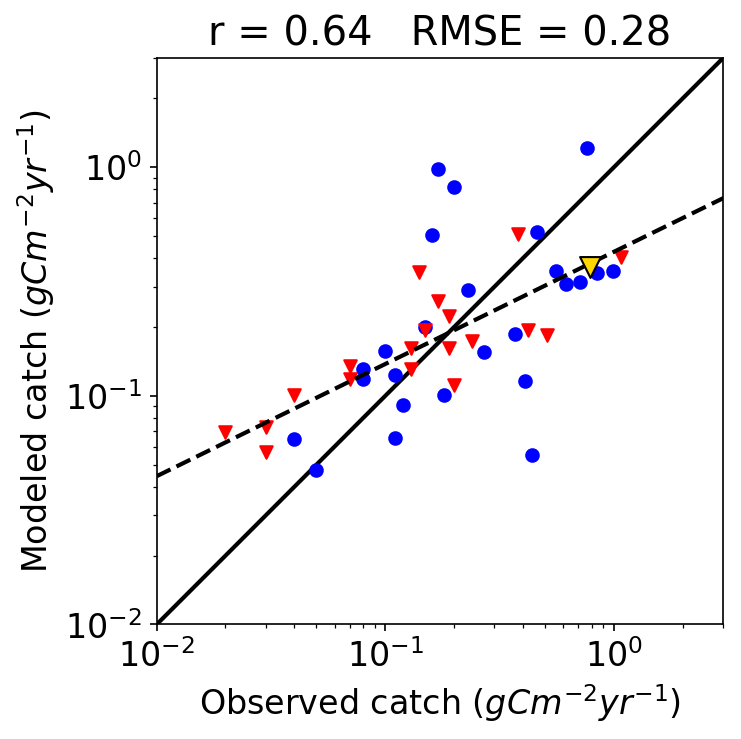

In [208]:
plt.plot([0.01,10],[0.01,10],'k', zorder = 0)
plt.plot([0.01,10],[(10**lparams3[1]*0.01**lparams3[0]),(10**lparams3[1]*10**lparams3[0])], 'k--', zorder = 1)

plt.yscale('log')
plt.xscale('log')
plt.xlabel('Observed catch ($gCm^{-2}yr^{-1}$)')
plt.ylabel('Modeled catch ($gCm^{-2}yr^{-1}$)')

ax = plt.gca()


ax.scatter(Scatch[(T<T_warm)],model_catch3[(T<T_warm)], 
             marker = 'o', color = 'blue')
ax.scatter(Scatch[(T>T_warm)],model_catch3[(T>T_warm)], 
             marker = 'v', color = 'red')

# for i in range(len(Scatch)):
#     plt.text(Scatch[i], model_catch3[i], lme_num[i], fontsize = 12)
#plt.text(Scatch[LME == 27],model_catch3[LME == 27], '27', fontsize = 15 )
ax.scatter(Scatch[LME == 27],model_catch3[LME == 27], 
             marker = 'v', edgecolors = 'k', color = 'gold', s = 100, zorder = 100)

# ax.scatter(Scatch[(T<T_warm) & (FD>ZP)],model_catch2[(T<T_warm) & (FD>ZP)], 
#             marker = 'v', color = 'blue')
# ax.scatter(Scatch[(T<T_warm) & (FD<ZP)],model_catch2[(T<T_warm) & (FD<ZP)], 
#             marker = 'o', color = 'blue')
# ax.scatter(Scatch[(T>T_warm) & (FD>ZP)],model_catch2[(T>T_warm) & (FD>ZP)], 
#             marker = 'v', color = 'red')
# ax.scatter(Scatch[(T>T_warm) & (FD<ZP)],model_catch2[(T>T_warm) & (FD<ZP)], 
#             marker = 'o', color = 'red')
ax.axis('square')

xmin = 0.01
xmax = 3
ax.set_xlim([xmin,xmax])
ax.set_ylim([xmin,xmax])

title = 'r = '+ '{:.2f}'.format(r) + '   RMSE = ' + '{:.2f}'.format(RMSE)
plt.title(title)

# Make plot for Nikki: predicted catch, and the catch-catch plot

In [137]:
# grab data

# use lme mask 
data = nc.Dataset("LME_x1_mask.nc", 'r')
mask = data.variables['LME_MASK'][:]

In [148]:
# calculate lme catch prediction 

pcatch_lme = np.copy(mask)

# initialize mean arrays
pcatch_lme= np.copy(mask)

# loop over LMEs
for lme in range(1,66+1):
    print str(lme)
    # check if LME is in the list
    if not LME[LME == lme]:
        print 'skipping '+str(lme)
        pcatch_lme[mask == lme] = np.NAN
    else:
        # set lme value
        pcatch_lme[mask == lme] = model_catch3[LME == lme]
        print model_catch3[LME == lme]

# reset mask (Nan out land)
pcatch_lme[pcatch_lme > 10**10] = np.NAN

1
[ 0.5076282]
2
[ 0.11851001]
3
[ 0.04760582]
4
[ 0.510985]
5
[ 0.26105863]
6
[ 0.130628]
7
[ 0.35095895]
8
[ 0.34337428]
9
[ 0.31635872]
10
skipping 10
11
[ 0.34804145]
12
[ 0.05699502]
13
[ 1.20898792]
14
[ 0.98272962]
15
[ 0.11844036]
16
[ 0.10096524]
17
[ 0.1348121]
18
[ 0.15665171]
19
[ 0.06475266]
20
[ 0.19921314]
21
[ 0.0909404]
22
[ 0.3503835]
23
skipping 23
24
[ 0.29173405]
25
[ 0.05497165]
26
[ 0.06551349]
27
[ 0.36470629]
28
[ 0.22287051]
29
[ 0.19357624]
30
[ 0.06953309]
31
[ 0.07294496]
32
[ 0.16241692]
33
skipping 33
34
[ 0.17434186]
35
skipping 35
36
[ 0.18398461]
37
[ 0.16262949]
38
[ 0.19401389]
39
skipping 39
40
skipping 40
41
skipping 41
42
skipping 42
43
skipping 43
44
skipping 44
45
skipping 45
46
[ 0.12365808]
47
[ 0.40351279]
48
skipping 48
49
[ 0.11128154]
50
[ 0.11592135]
51
[ 0.15520554]
52
[ 0.52214705]
53
[ 0.1315454]
54
[ 0.81661294]
55
skipping 55
56
skipping 56
57
skipping 57
58
skipping 58
59
[ 0.18677089]
60
[ 0.30783215]
61
skipping 61
62
skipping 62


/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater


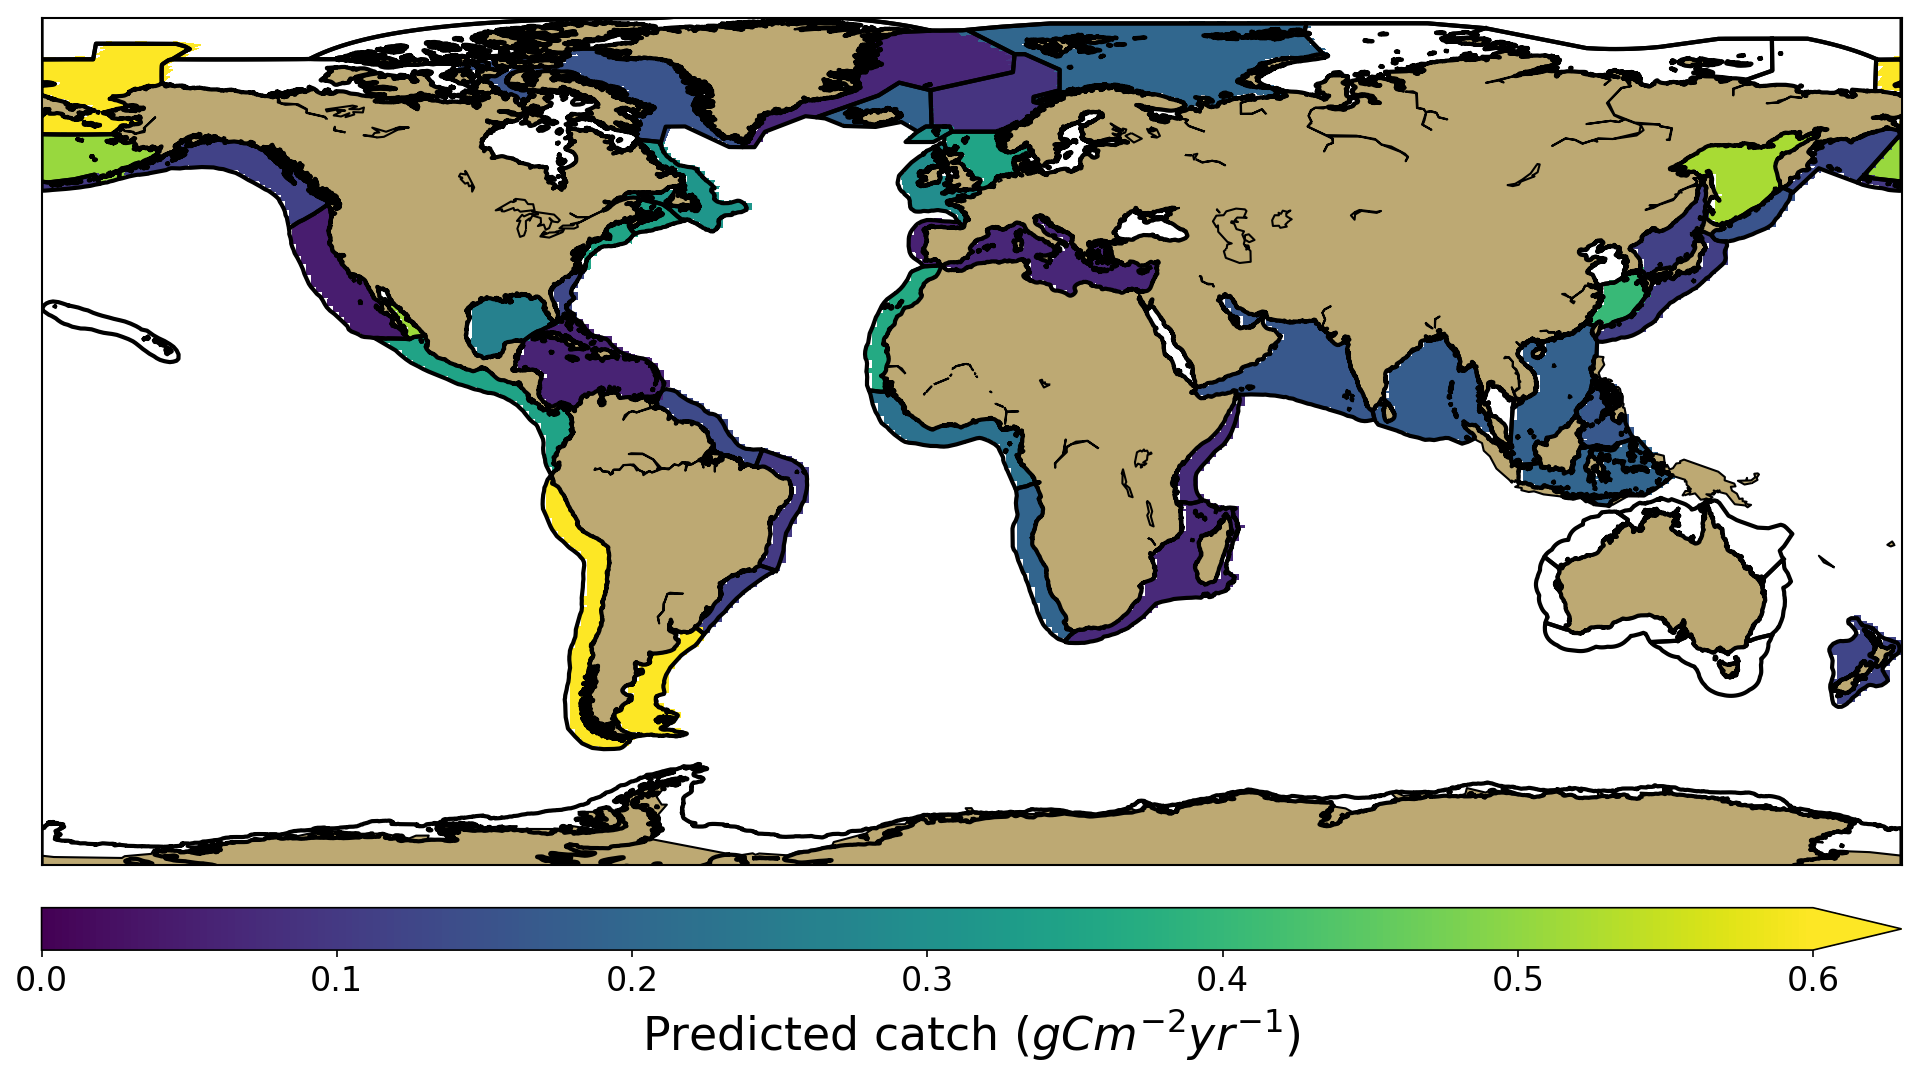

In [211]:
# plot in basemap with LME boundaries
var = pcatch_lme
temp = np.ma.concatenate((var,var),1)

ax = plt.figure(figsize=(16,20), facecolor = 'w')

# limits of plot
limN, limS, limE, limW = 84.,-80.,180,-180


#m = Basemap(projection='hammer',lon_0=0)
m = Basemap(projection='cyl', llcrnrlon=limW, \
      urcrnrlon=limE, llcrnrlat=limS, urcrnrlat=limN, resolution='c')
m.drawcoastlines()
m.drawmapboundary()
m.fillcontinents(color='#BDA973', lake_color='#BDA973')

x, y = m(lon,lat)
#im1 = m.pcolormesh(x,y,temp,vmin = 0, vmax = 0.6) #, cmap = cm.phase)
im1 = m.pcolormesh(x,y,temp,vmin = 0, vmax = 0.6) #, cmap = cm.phase)

cbar = m.colorbar(im1,location='bottom',pad="5%",extend = 'max')
cbar.set_label('Predicted catch ($gCm^{-2}yr^{-1}$)', fontsize = 22)

m.readshapefile('LME66/LMEs66', 'LME') # the second argment is a name for the shapefile data
for info, shape in zip(m.LME_info, m.LME):
        x, y = zip(*shape) 
        m.plot(x, y, marker=None,color='k', linewidth = '2')       
plt.show()

In [151]:
# same with observed catch

# calculate lme catch prediction 

scatch_lme = np.copy(mask)

# initialize mean arrays
scatch_lme= np.copy(mask)

# loop over LMEs
for lme in range(1,66+1):
    print str(lme)
    # check if LME is in the list
    if not LME[LME == lme]:
        print 'skipping '+str(lme)
        scatch_lme[mask == lme] = np.NAN
    else:
        # set lme value
        scatch_lme[mask == lme] = Scatch[LME == lme]
        print Scatch[LME == lme]

# reset mask (Nan out land)
scatch_lme[scatch_lme > 10**10] = np.NAN


1
[ 0.16]
2
[ 0.08]
3
[ 0.05]
4
[ 0.38]
5
[ 0.17]
6
[ 0.13]
7
[ 0.99]
8
[ 0.84]
9
[ 0.71]
10
skipping 10
11
[ 0.14]
12
[ 0.03]
13
[ 0.76]
14
[ 0.17]
15
[ 0.07]
16
[ 0.04]
17
[ 0.07]
18
[ 0.1]
19
[ 0.04]
20
[ 0.15]
21
[ 0.12]
22
[ 0.56]
23
skipping 23
24
[ 0.23]
25
[ 0.44]
26
[ 0.11]
27
[ 0.79]
28
[ 0.19]
29
[ 0.42]
30
[ 0.02]
31
[ 0.03]
32
[ 0.13]
33
skipping 33
34
[ 0.24]
35
skipping 35
36
[ 0.51]
37
[ 0.19]
38
[ 0.15]
39
skipping 39
40
skipping 40
41
skipping 41
42
skipping 42
43
skipping 43
44
skipping 44
45
skipping 45
46
[ 0.11]
47
[ 1.08]
48
skipping 48
49
[ 0.2]
50
[ 0.41]
51
[ 0.27]
52
[ 0.46]
53
[ 0.08]
54
[ 0.2]
55
skipping 55
56
skipping 56
57
skipping 57
58
skipping 58
59
[ 0.37]
60
[ 0.62]
61
skipping 61
62
skipping 62
63
skipping 63
64
skipping 64
65
[ 0.18]
66
skipping 66


/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


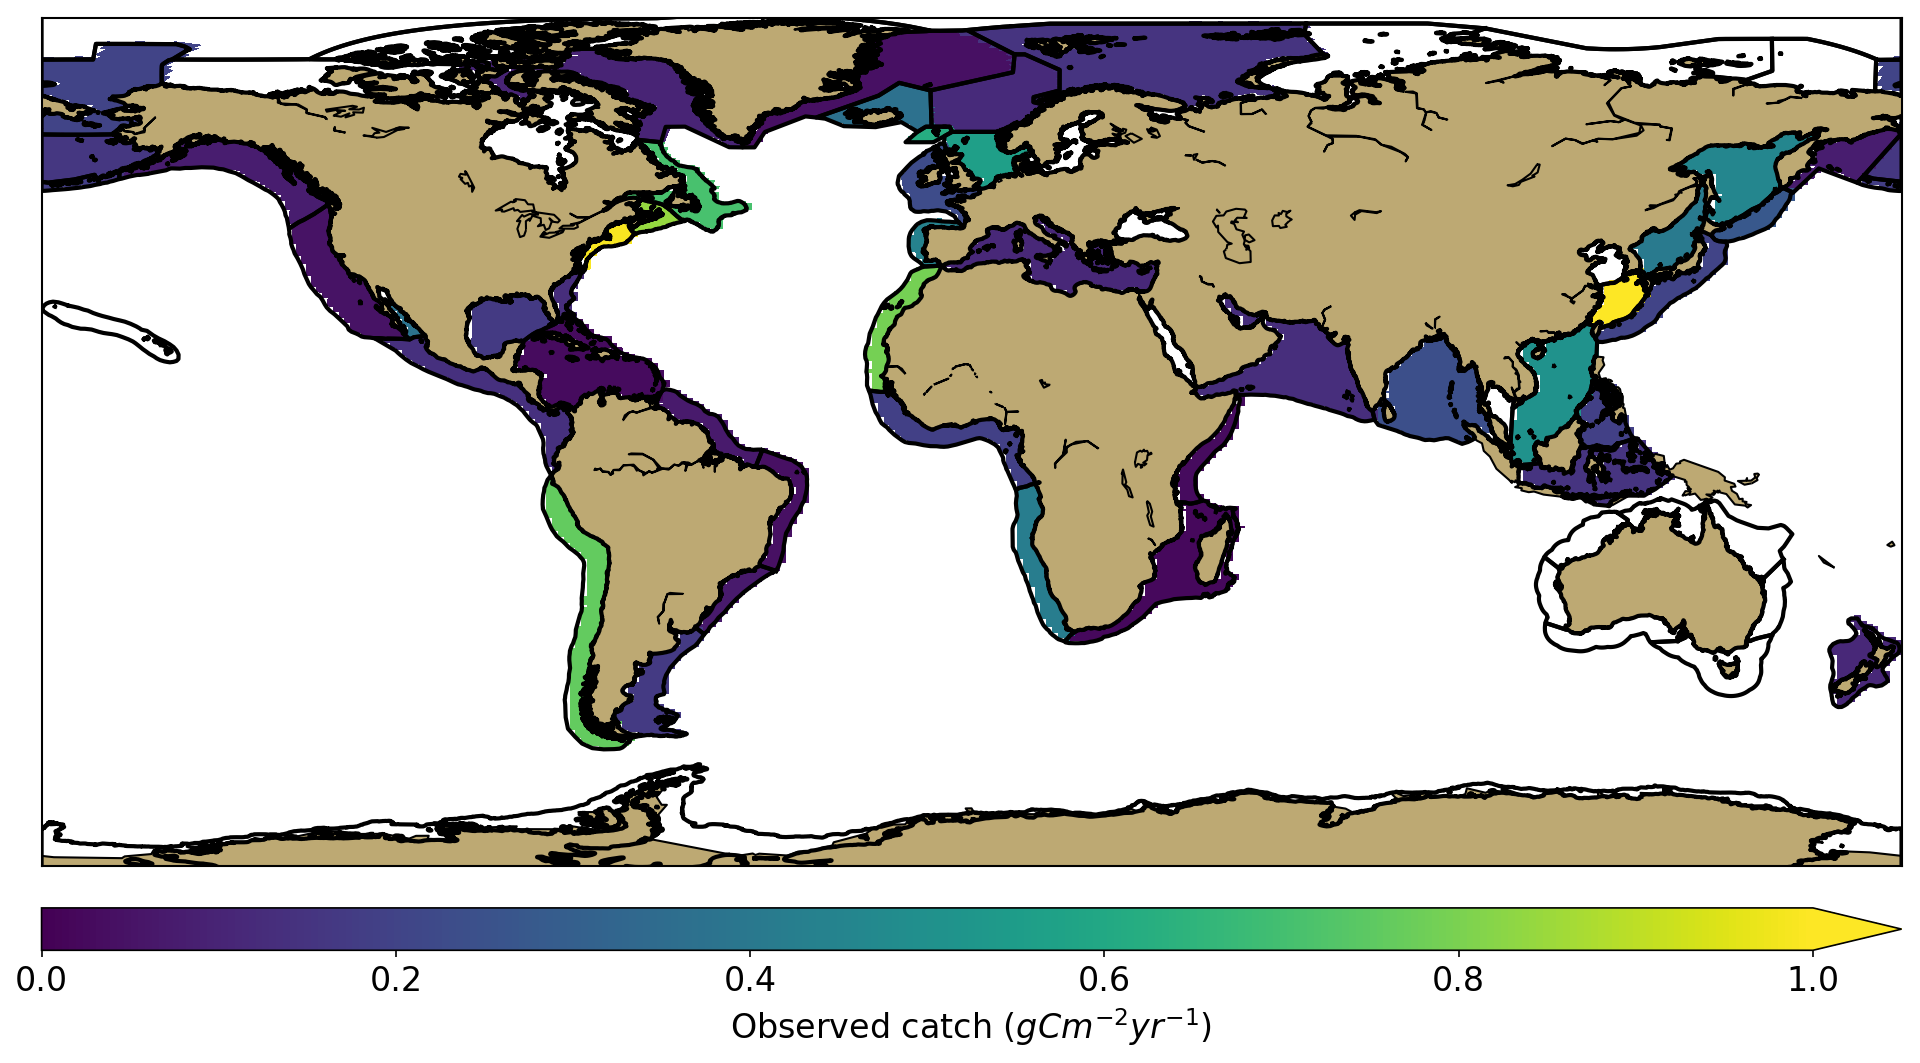

In [180]:
# plot in basemap with LME boundaries
var = scatch_lme
temp = np.ma.concatenate((var,var),1)

ax = plt.figure(figsize=(16,20), facecolor = 'w')

# limits of plot
limN, limS, limE, limW = 84.,-80.,180,-180


#m = Basemap(projection='hammer',lon_0=0)
m = Basemap(projection='cyl', llcrnrlon=limW, \
      urcrnrlon=limE, llcrnrlat=limS, urcrnrlat=limN, resolution='c')
m.drawcoastlines()
m.drawmapboundary()
m.fillcontinents(color='#BDA973', lake_color='#BDA973')

x, y = m(lon,lat)
im1 = m.pcolormesh(x,y,temp, vmin = 0, vmax = 1) #, cmap = cm.phase)

#im1 = m.pcolormesh(x,y,temp,vmin = 0, vmax = 0.6) #, cmap = cm.phase)
cbar = m.colorbar(im1,location='bottom',pad="5%", extend = 'max')
cbar.set_label('Observed catch ($gCm^{-2}yr^{-1}$)')

m.readshapefile('LME66/LMEs66', 'LME') # the second argment is a name for the shapefile data
for info, shape in zip(m.LME_info, m.LME):
        x, y = zip(*shape) 
        m.plot(x, y, marker=None,color='k', linewidth = '2')       
plt.show()

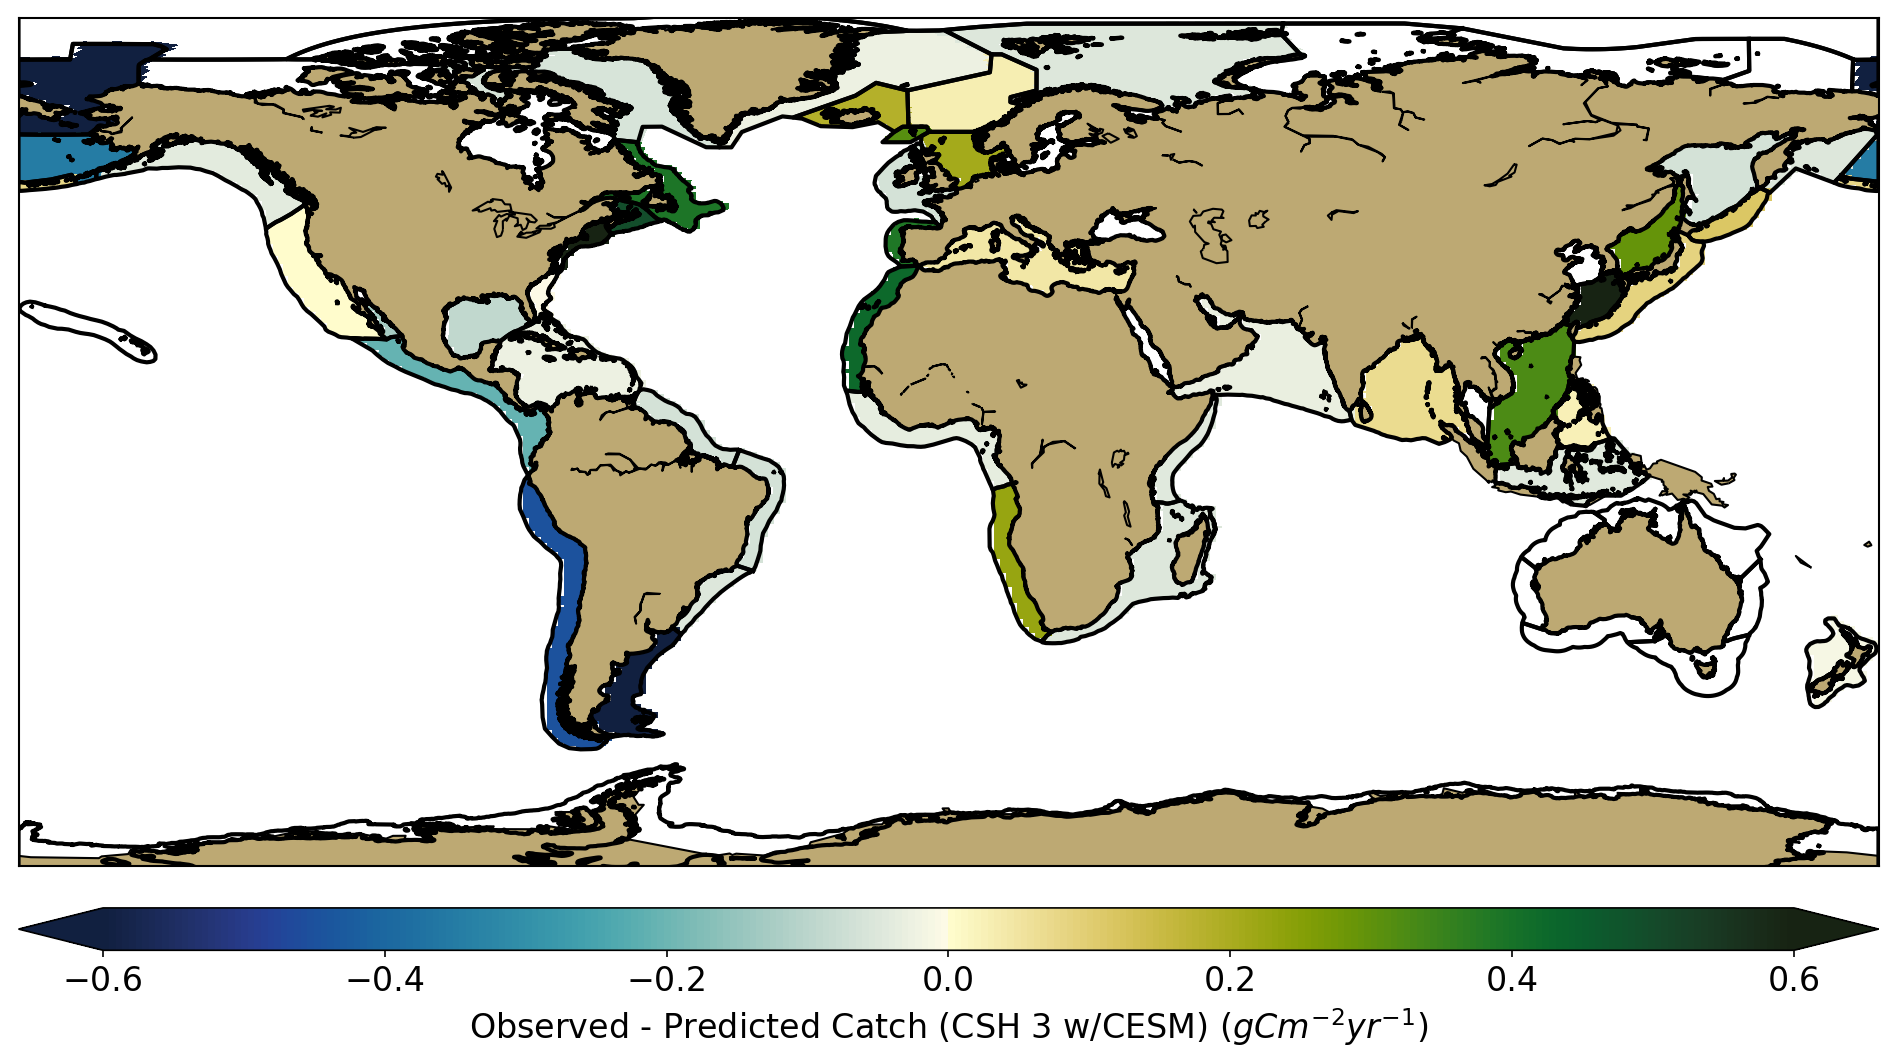

In [177]:
# plot in basemap with LME boundaries
var = scatch_lme - pcatch_lme
temp = np.ma.concatenate((var,var),1)

ax = plt.figure(figsize=(16,20), facecolor = 'w')

# limits of plot
limN, limS, limE, limW = 84.,-80.,180,-180

#m = Basemap(projection='hammer',lon_0=0)
m = Basemap(projection='cyl', llcrnrlon=limW, \
      urcrnrlon=limE, llcrnrlat=limS, urcrnrlat=limN, resolution='c')
m.drawcoastlines()
m.drawmapboundary()
m.fillcontinents(color='#BDA973', lake_color='#BDA973')

x, y = m(lon,lat)
im1 = m.pcolormesh(x,y,temp, vmin = -0.6, vmax = 0.6 , cmap = cm.delta)
#im1 = m.pcolormesh(x,y,temp , cmap = cm.delta)

cbar = m.colorbar(im1,location='bottom',pad="5%", extend = 'both')
cbar.set_label('Observed - Predicted Catch (CSH 3 w/CESM) ($gCm^{-2}yr^{-1}$)')

m.readshapefile('LME66/LMEs66', 'LME') # the second argment is a name for the shapefile data
for info, shape in zip(m.LME_info, m.LME):
        x, y = zip(*shape) 
        m.plot(x, y, marker=None,color='k', linewidth = '2')       
plt.show()

# Compare with GFDL model

In [162]:
# import GFDL results here to compare
model3_G = [ 0.29032875,  0.14704514,  0.06488151,  0.7239569 ,  0.17548345,
        0.26572775,  0.58224248,  0.314649  ,  0.22644979,  0.28607678,
        0.03011048,  0.49044854,  0.52168411,  0.27035573,  0.04999013,
        0.26328279,  0.09124798,  0.11140998,  0.22590462,  0.09453516,
        0.43790382,  0.27685842,  0.17182668,  0.08851894,  0.3899702 ,
        0.32271395,  0.31265984,  0.03516146,  0.04284158,  0.08388417,
        0.15834012,  0.15592456,  0.1613268 ,  0.08511202,  0.15259366,
        0.39602705,  0.08902781,  0.25199941,  0.25186321,  0.39486556,
        0.21736951,  0.30113883,  0.19592868,  0.34281445,  0.1706736 ]
model3_G = np.asarray(model3_G)

In [163]:

pcatch_lme_g= np.copy(mask)

# initialize mean arrays
pcatch_lme_g= np.copy(mask)

# loop over LMEs
for lme in range(1,66+1):
    #print str(lme)
    # check if LME is in the list
    if not LME[LME == lme]:
        #print 'skipping '+str(lme)
        pcatch_lme_g[mask == lme] = np.NAN
    else:
        # set lme value
        pcatch_lme_g[mask == lme] = model3_G[LME == lme]
        #print Scatch[LME == lme]

# reset mask (Nan out land)
pcatch_lme_g[pcatch_lme_g > 10**10] = np.NAN


/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


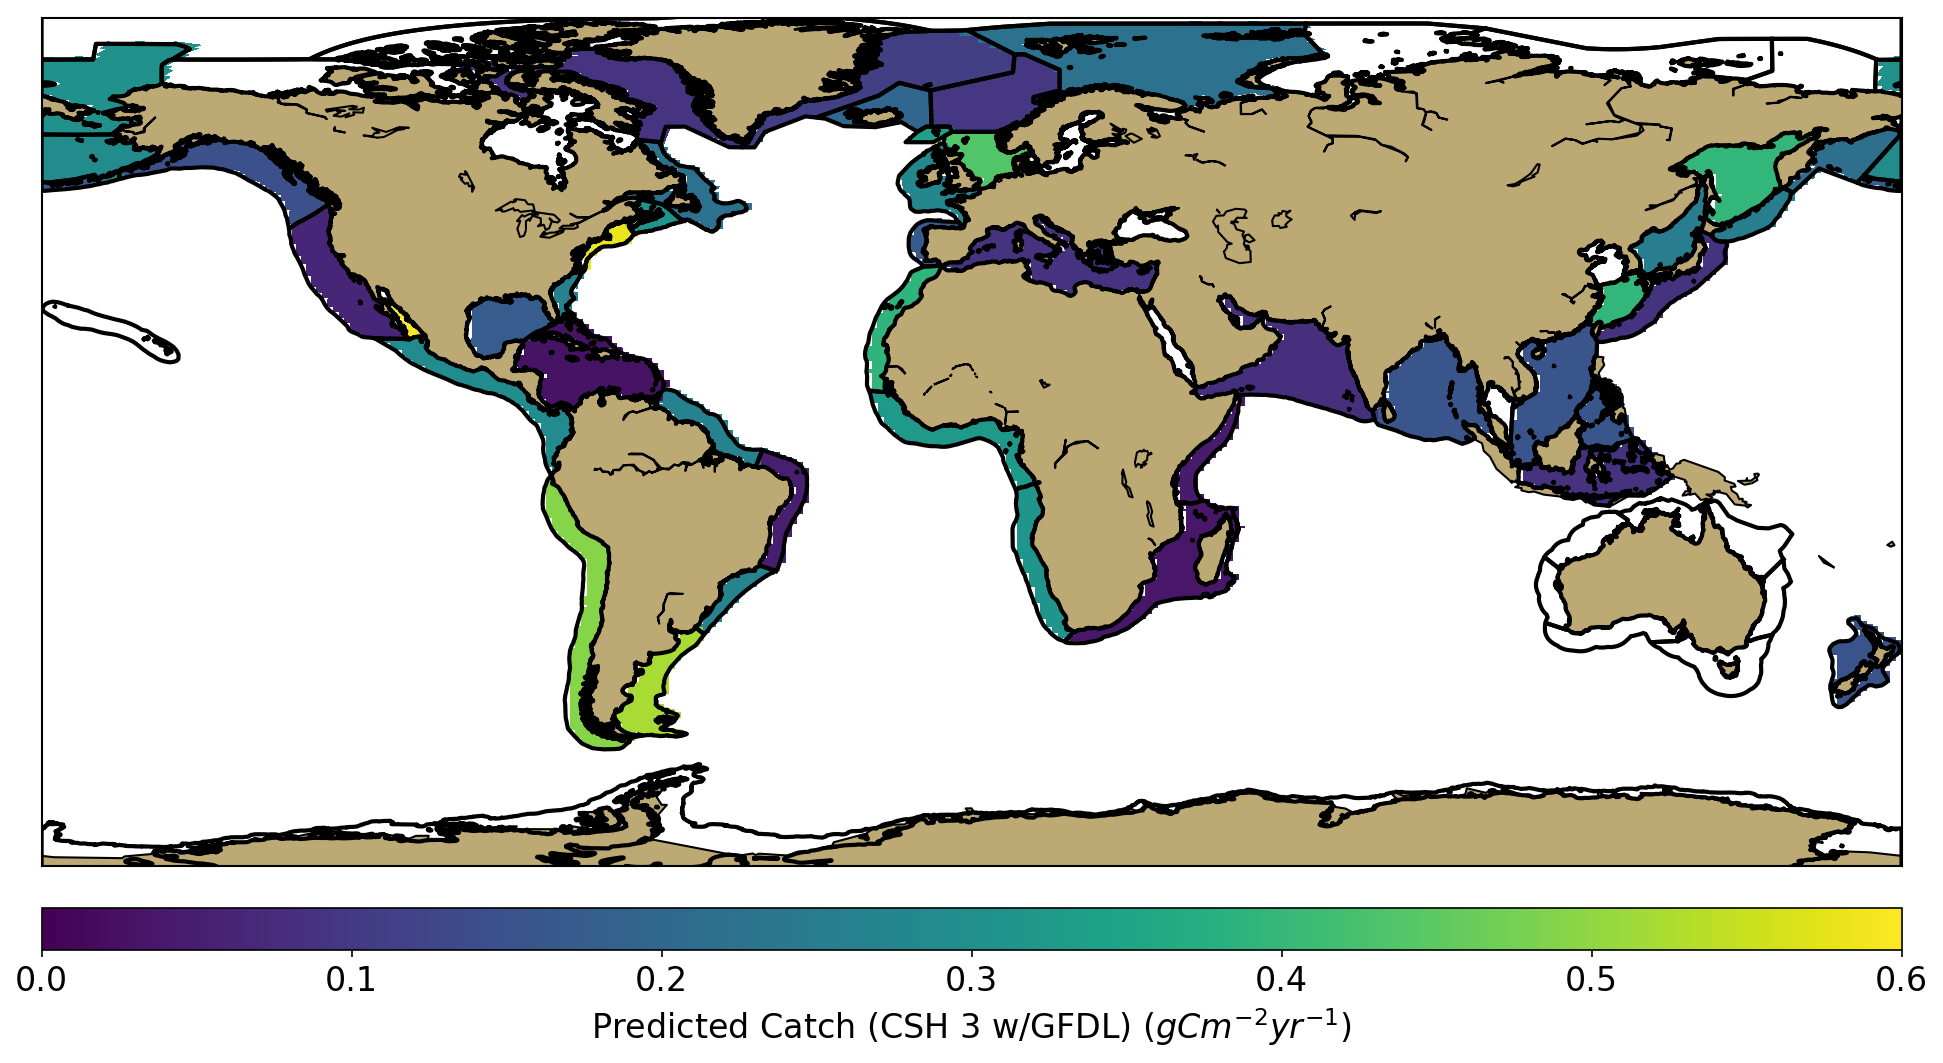

In [170]:
# plot in basemap with LME boundaries
var = pcatch_lme_g
temp = np.ma.concatenate((var,var),1)

ax = plt.figure(figsize=(16,20), facecolor = 'w')

# limits of plot
limN, limS, limE, limW = 84.,-80.,180,-180

#m = Basemap(projection='hammer',lon_0=0)
m = Basemap(projection='cyl', llcrnrlon=limW, \
      urcrnrlon=limE, llcrnrlat=limS, urcrnrlat=limN, resolution='c')
m.drawcoastlines()
m.drawmapboundary()
m.fillcontinents(color='#BDA973', lake_color='#BDA973')

x, y = m(lon,lat)
im1 = m.pcolormesh(x,y,temp,vmin = 0, vmax = 0.6) #, cmap = cm.phase)
cbar = m.colorbar(im1,location='bottom',pad="5%")
cbar.set_label('Predicted Catch (CSH 3 w/GFDL) ($gCm^{-2}yr^{-1}$)')

m.readshapefile('LME66/LMEs66', 'LME') # the second argment is a name for the shapefile data
for info, shape in zip(m.LME_info, m.LME):
        x, y = zip(*shape) 
        m.plot(x, y, marker=None,color='k', linewidth = '2')       
plt.show()

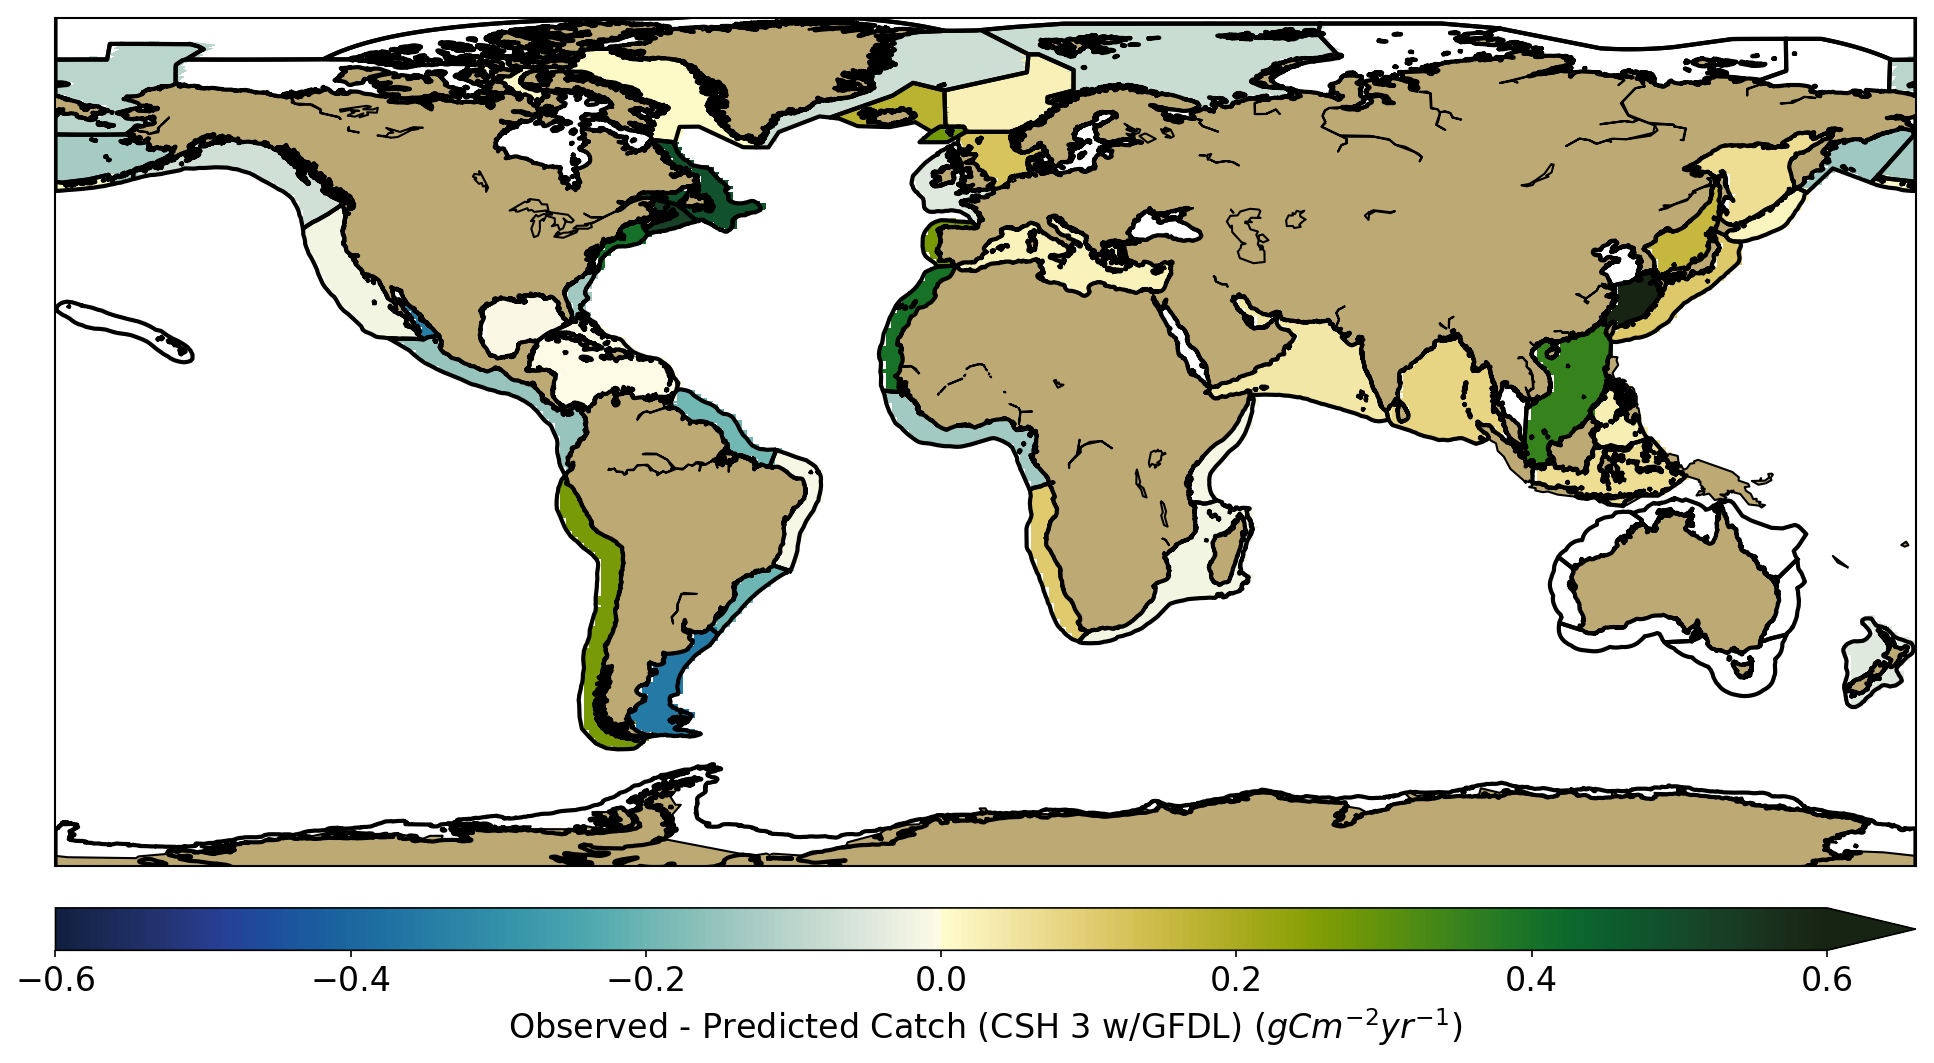

In [173]:
# plot in basemap with LME boundaries
var = scatch_lme - pcatch_lme_g
temp = np.ma.concatenate((var,var),1)

ax = plt.figure(figsize=(16,20), facecolor = 'w')

# limits of plot
limN, limS, limE, limW = 84.,-80.,180,-180

#m = Basemap(projection='hammer',lon_0=0)
m = Basemap(projection='cyl', llcrnrlon=limW, \
      urcrnrlon=limE, llcrnrlat=limS, urcrnrlat=limN, resolution='c')
m.drawcoastlines()
m.drawmapboundary()
m.fillcontinents(color='#BDA973', lake_color='#BDA973')

x, y = m(lon,lat)
im1 = m.pcolormesh(x,y,temp, vmin = -0.6, vmax = 0.6 , cmap = cm.delta)
cbar = m.colorbar(im1,location='bottom',pad="5%", extend = 'max')
cbar.set_label('Observed - Predicted Catch (CSH 3 w/GFDL) ($gCm^{-2}yr^{-1}$)')

m.readshapefile('LME66/LMEs66', 'LME') # the second argment is a name for the shapefile data
for info, shape in zip(m.LME_info, m.LME):
        x, y = zip(*shape) 
        m.plot(x, y, marker=None,color='k', linewidth = '2')       
plt.show()

In [190]:
# print out details for Nikki:

#This is LME # 27

print Scatch[LME == 27]

print model_catch3[LME == 27]

print model3_G[LME == 27]

[ 0.79]
[ 0.36470629]
[ 0.3899702]


In [187]:
model_catch3.shape

(45,)